<a href="https://colab.research.google.com/github/therealfortune/tensorflow-fortune/blob/master/Cat_v_Dog(Transfer_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-12-20 17:32:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M  83.6MB/s    in 1.0s    

2021-12-20 17:32:38 (83.6 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weight_file = "/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None
)

pre_trained_model.load_weights(local_weight_file)

for layer in pre_trained_model.layers:
  layer.trainable = True

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape = ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape =  (None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)

model.compile(
    optimizer = RMSprop(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

LOADING OUR OWN DATASET

In [5]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 112MB/s] 


In [6]:
import os
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [7]:
base_dir = "tmp/cats_and_dogs_filtered"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir,'cats' )
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cats_fname = os.listdir(train_cats_dir)
train_dogs_fname = os.listdir(train_dogs_dir)

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    height_shift_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    target_size=(150,150),
    class_mode='binary'
)

# Validation data should not be augumented
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    target_size=(150,150),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print('/Accuracy reached 96% , stopping training now')
      self.model.stop_training=True
callback = Callback()

In [12]:
history = model.fit(
    train_generator,
    validation_data= validation_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_steps = 50,
    callbacks = [callback],
    verbose=1
)

Epoch 1/100
100/100 [==============================] - 40s 403ms/step - loss: 0.3168 - accuracy: 0.8780 - val_loss: 1.0007 - val_accuracy: 0.7810
Epoch 2/100
100/100 [==============================] - 39s 384ms/step - loss: 0.2907 - accuracy: 0.8860 - val_loss: 1.3546 - val_accuracy: 0.9130
Epoch 3/100
100/100 [==============================] - 29s 285ms/step - loss: 0.2908 - accuracy: 0.8925 - val_loss: 0.9465 - val_accuracy: 0.8380
Epoch 4/100
100/100 [==============================] - 29s 288ms/step - loss: 0.2668 - accuracy: 0.8985 - val_loss: 6.0316 - val_accuracy: 0.8030
Epoch 5/100
100/100 [==============================] - 30s 302ms/step - loss: 0.3216 - accuracy: 0.8850 - val_loss: 0.3709 - val_accuracy: 0.8940
Epoch 6/100
100/100 [==============================] - 29s 291ms/step - loss: 0.2475 - accuracy: 0.9050 - val_loss: 73.6965 - val_accuracy: 0.5980
Epoch 7/100
100/100 [==============================] - 29s 287ms/step - loss: 0.2714 - accuracy: 0.8990 - val_loss: 18.9875

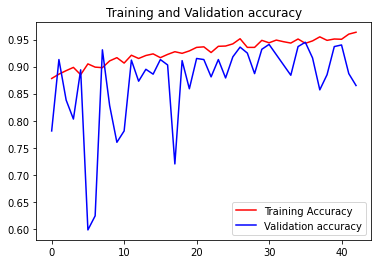

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
lsss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()